### Parses large `results.csv` file generated by `run_evaluations.sh` 

In [1]:
# !pip install -U pandas # 1.4.2

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

plot_path = Path('/home/user/kew/INSTALLS/fudge/analysis/plots')

In [3]:
print(pd.__version__)


1.4.2


In [52]:
mapping = {
#     'file': 'file',
    'test_set': 'Target Level',
    'params': 'Method',
    'sari': 'SARI',
    'bertscore_f1_ref': 'BERTScore',
    'bleu': 'BLEU',
    'fkgl': 'FKGL',
    'intra_dist1': 'Dist-1',
    'Compression ratio': 'Comp. ratio', 
    'Sentence splits': 'Sent. splits',
    'Levenshtein similarity': 'Lev. sim.',
    'Exact copies': 'Copies', 
    'Additions proportion': 'Add prop.',
    'Deletions proportion': 'Del prop.',
}

\begin{tabular}{lrrrrrrr}
 & FKGL & Comp. ratio & Sent. splits & Lev. sim. & Copies & Add prop. & Del prop. \\
Simp-1 & 7.97 & 1.01 & 1.19 & 0.90 & 0.44 & 0.10 & 0.10 \\
Simp-2 & 6.41 & 0.98 & 1.42 & 0.82 & 0.23 & 0.17 & 0.20 \\
Simp-3 & 4.91 & 0.92 & 1.55 & 0.73 & 0.13 & 0.24 & 0.31 \\
Simp-4 & 3.40 & 0.85 & 1.79 & 0.65 & 0.09 & 0.30 & 0.43 \\
\end{tabular}



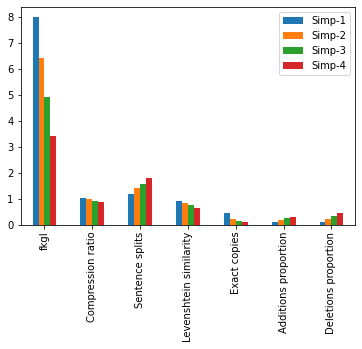

In [53]:
ground_truth = {'Simp-1': {'fkgl': 7.967424772673326, 'Compression ratio': 1.0088417673071652, 'Sentence splits': 1.1946118721461185, 'Levenshtein similarity': 0.9038902274159766, 'Exact copies': 0.4410958904109589, 'Additions proportion': 0.09501851581521988, 'Deletions proportion': 0.0990403784826063, 'Lexical complexity score': 8.55938268290073}, 'Simp-2': {'fkgl': 6.411884361286063, 'Compression ratio': 0.9812542863921209, 'Sentence splits': 1.4155807365439093, 'Levenshtein similarity': 0.8199736978615051, 'Exact copies': 0.22946175637393768, 'Additions proportion': 0.17032500978943574, 'Deletions proportion': 0.1987557520780373, 'Lexical complexity score': 8.517484017433077}, 'Simp-3': {'fkgl': 4.9119896238676795, 'Compression ratio': 0.9246498121085542, 'Sentence splits': 1.5486515641855447, 'Levenshtein similarity': 0.7346835852500192, 'Exact copies': 0.13268608414239483, 'Additions proportion': 0.24369044331926637, 'Deletions proportion': 0.3137163907153821, 'Lexical complexity score': 8.467478933429538}, 'Simp-4': {'fkgl': 3.3956874275197073, 'Compression ratio': 0.8485376584110984, 'Sentence splits': 1.7920572916666666, 'Levenshtein similarity': 0.6461078981377691, 'Exact copies': 0.08984375, 'Additions proportion': 0.2994676753866754, 'Deletions proportion': 0.4317465655764906, 'Lexical complexity score': 8.525171061087843}}

gdf = pd.DataFrame(ground_truth)

gdf.drop(index=['Lexical complexity score'], inplace=True)
gdf.plot(kind='bar')

gdf = gdf.transpose().rename(columns=mapping)
gdf = gdf.style.format(na_rep='-', precision=2)
print(gdf.to_latex())

In [58]:
def parse_muss_path(file_path):
    cond_model = ''
    file_name = file_path[-1] # newsela_manual_v0_v2_dev_lr0.75_ls0.82_wr0.94_td0.22.pred
    test_set = '_'.join(file_name.split('_')[:5])
    params = 'MUSS' #','.join(file_name.split('_')[5:]).rstrip('.pred')
    return cond_model, test_set, params

def parse_fudge_path(file_path):
    cond_model = file_path[8].split('_')[1].upper()
    test_set = file_path[9]
    params = file_path[-1]
    return cond_model, test_set, params

def parse_supervised_path(file_path):
    # "/srv/scratch6/kew/ats/supervised/results/newsela_manual_v0_v4_test/lambda*"
    cond_model = ''
    test_set = file_path[7]
    params = 'SUPER' #file_path[-1]
    return cond_model, test_set, params

def get_file_info(file_path):
    file_path = file_path.split('/')
    method = file_path[5]
    if method == 'fudge':
        cond_model, test_set, params = parse_fudge_path(file_path)
    elif method == 'muss':
        cond_model, test_set, params = parse_muss_path(file_path)
    elif method == 'supervised':
        cond_model, test_set, params = parse_supervised_path(file_path)
    return method, cond_model, test_set, params

def filter_rows(df):

    df = df[df["params"].str.contains("pretopk100|lambda5.0")==False].reset_index(drop=True)
    # ignore results from inference runs with default lambda=5.0 and pretopk=100
    return df
   
def read_data(csv_file):
    df = pd.read_csv(
        csv_file, 
        header=0, 
        sep=';',
    )

    df['method'], df['cond_model'], df['test_set'], df['params'] = zip(*df['file'].apply(get_file_info))
    
    df['split'] = df['test_set'].apply(lambda x: x.split('_')[-1])
    df['test_set'] = df['test_set'].apply(
        lambda x: ' '.join(x.split('_')[3:4]).replace('v', 'Simp-'))

    # characters for plotting
    df['cond_model'] = df['cond_model'].apply(lambda x: re.sub('L', 'ℬ_Simp-', x))
    df['params'] = df['params'].apply(lambda x: x.split('_')[0].replace('lambda', 'λ='))

    # characters for latex
    df['params'] = df.apply(lambda x: f"{str(x.cond_model)} {str(x.params)}", axis=1)
    df['params'] = df['params'].apply(lambda x: x.replace('ℬ_Simp-', '$\mathcal{B}_{Simp-}'))
    df['params'] = df['params'].apply(lambda x: x.replace('λ=', '\lambda=$',))
    
#     print(df['params'])
    df.sort_values(['split', 'test_set', 'method', 'params'], inplace=True)
    
#     TODO: replace \lambda=$0.0 with $\mathcal{G}$
    df['params'] = df['params'].apply(lambda x: '$\mathcal{G}$' if '0.0' in x else x)
#     df['method'] = df.loc[df['params'].str.contains('0.0'), 1] = '$\mathcal{G}$'
    
    return df.reset_index(drop=True, inplace=False)

def generate_results_table_for_controlled_simplification_levels(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    df = df[(df["test_set"].str[-2:] == df["params"].str[:2]) | (df["method"] != "fudge")]
    df = df[(df["test_set"] != "L0-L4") | (df["params"].str.contains("L4-lambda4.0|L4-lambda5.0")==False)]
    return df.reset_index(drop=True, inplace=False)

def generate_results_table_for_newsela4_classifier_on_all_levels(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    print(len(df))
    df = df[df["file"].str.contains("pretopk100")==False]
    print(len(df))
    ignore_settings = [
        "L1-lambda0.0", "L1-lambda1.0", "L1-lambda8.0", 
        'L2-lambda0.0', "L2-lambda1.0", "L2-lambda10.0",
        "L3-lambda0.0", "L3-lambda1.0", "L3-lambda10.0", 
        "L4-lambda0.0",
    ]
    df = df[df["params"].isin(ignore_settings)==False]
    print(len(df))

    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] != "L0-L3"))==False]
    df = df[((df["params"] == "L4-lambda1.0") & (df["test_set"] == "L0-L4"))==False]
    print(len(df))
    
    return df.reset_index(drop=True, inplace=False)


def generate_large_results_table_article_paragraphs(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    print(len(df))
    df = df[df["file"].str.contains("pretopk100")==False]
    print(len(df))
    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] == "L0-L1"))==False]
    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] == "L0-L2"))==False]
    print(len(df))
    
    return df.reset_index(drop=True, inplace=False)


def generate_large_results_table_article_para_sents(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    df = df[(df['file'].str.contains('article_paragraphs'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0'))==False]
    df = df[(df['file'].str.contains('newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda1.0'))==False]
#     df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v2_test/lambda2.0'))==False]
    df = df[(df['file'].str.contains('newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda1.0'))==False]
#     df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v3_test/lambda6.0'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda1.0'))==False]

    df.reset_index(drop=True, inplace=False)
    
    df = df.rename(columns=mapping)
    df = df[list(mapping.values())]
    
    return df


def generate_large_results_table_lp_article_paragraphs(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    # simp-1
    #     df = df[df["file"].str.contains("/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_para_sents/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt")]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_para_sents/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda8.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    
    # simp-2
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_paragraphs/newsela_manual_v0_v2_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_paragraphs/newsela_manual_v0_v2_test/lambda10.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda3.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]

    # simp-3
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_paragraphs/newsela_manual_v0_v3_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_paragraphs/newsela_manual_v0_v3_test/lambda10.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda3.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda6.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"] 
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v3_test/lambda6.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    
    # simp-4
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda4.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda8.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != ""]
    df = df[df["file"] != ""]

    df.reset_index(drop=True, inplace=False)
    
    df = df.rename(columns=mapping)
    df = df[list(mapping.values())]
    
    return df


df = read_data('/home/user/kew/INSTALLS/fudge/results_on_test.csv')
# df = generate_large_results_table_article_para_sents(df)
df = generate_large_results_table_lp_article_paragraphs(df)


#     keep_cols = ['test_set', 'split', 'method', 'params', 'bleu', 'sari', 'fkgl',
#                  'bertscore_f1_ref', 'bertscore_f1_src', 'intra_dist1', 'intra_dist2',
#                  'Compression ratio', 'Sentence splits', 'Levenshtein similarity', 'Exact copies', 
#                  'Additions proportion', 'Deletions proportion', 'Lexical complexity score', 'file']


#     df.drop(columns=[col for col in df if col not in keep_cols], inplace=True)
#     df = df[keep_cols]  #    OR    df = df.ix[:, keep_cols]
df


,Target Level,Method,SARI,BERTScore,BLEU,FKGL,Dist-1,Comp. ratio,Sent. splits,Lev. sim.,Copies,Add prop.,Del prop.
0,Simp-1,$\mathcal{G}$,36.609072,81.675690,65.159409,9.152054,0.915912,0.974721,1.015068,0.885676,0.175342,0.079782,0.108260
4,Simp-1,$\mathcal{B}_{Simp-}1 \lambda=$1.0,36.104563,80.445397,61.682602,8.812060,0.921739,0.941372,1.006256,0.875990,0.131507,0.074644,0.134177
11,Simp-1,MUSS,35.689195,75.949240,50.607168,7.752044,0.937497,0.811370,1.003425,0.844320,0.013699,0.074010,0.235342
12,Simp-1,SUPER,32.494886,88.186944,78.491987,9.357700,0.920551,0.991141,1.038813,0.990262,0.887671,0.006629,0.014658
14,Simp-2,$\mathcal{G}$,35.006925,73.534739,52.844353,9.124967,0.915279,0.973018,1.015581,0.885422,0.178470,0.079974,0.109788
18,Simp-2,$\mathcal{B}_{Simp-}2 \lambda=$4.0,38.324349,70.747864,48.024293,7.422022,0.908133,0.964747,1.251747,0.840843,0.079320,0.122507,0.170452
25,Simp-2,MUSS,36.566496,65.907264,28.724531,7.269932,0.941795,0.778172,1.025260,0.752531,0.002833,0.147472,0.345488
26,Simp-2,SUPER,31.119814,78.216690,61.781532,8.877532,0.919900,0.990798,1.095467,0.978994,0.796034,0.015011,0.026788
28,Simp-3,$\mathcal{G}$,30.874249,65.062439,38.687433,9.092561,0.913635,0.978205,1.014563,0.886515,0.181230,0.081753,0.107770
32,Simp-3,$\mathcal{B}_{Simp-}3 \lambda=$4.0,39.558903,61.459017,32.464732,6.438555,0.895448,1.002105,1.453991,0.805479,0.019417,0.196297,0.203187


In [59]:
cm_asc = sns.light_palette("#2ecc71", as_cmap=True)
cm_desc = sns.light_palette("#2ecc71", as_cmap=True, reverse=True)

def get_closest(s, props='', tgt_val=None):
    closest = min(s, key=lambda x: abs(x-tgt_val))
#     print(tgt_val, closest)
    return np.where(s == closest, props, '')

def make_pretty(styler, max_cols=['SARI', 'BERTScore'], min_cols=['FKGL'], hidden_cols=['BLEU'], kwargs=None):
#     print(kwargs)
    styler.background_gradient(cmap=cm_asc, axis=0, subset=max_cols)

#     styler.background_gradient(cmap=cm_desc, axis=0, subset=min_cols)
    # styler.hide(subset=hidden_cols, axis=0) # AttributeError: 'Styler' object has no attribute 'hide'
    styler.format(na_rep='-', precision=2)
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['FKGL'], tgt_val=kwargs['fkgl'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Comp. ratio'], tgt_val=kwargs['Compression ratio'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Sent. splits'], tgt_val=kwargs['Sentence splits'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Lev. sim.'], tgt_val=kwargs['Levenshtein similarity'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Copies'], tgt_val=kwargs['Exact copies'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Add prop.'], tgt_val=kwargs['Additions proportion'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Del prop.'], tgt_val=kwargs['Deletions proportion'])

    return styler

# df.style.hide(['BLEU'])
# set multilevel index
# sty_df = df.set_index(['Target Level', 'Method']).drop(columns=['BLEU', 'Dist-1'])
### Not suitable fir getting colour gradients per level
# sty_df = sty_df.style.pipe(make_pretty)
# print(sty_df.to_latex(
#     column_format=f'@{{}}{"X"*(len(sty_df.columns)+len(sty_df.index.names))}@{{}}',
#     hrules=False, 
#     convert_css=True,
#     sparse_index=True,
#     sparse_columns=True,
#     multirow_align='c',
#     multicol_align='c',
# #     environment=f'tabularx{{\\textwidth}}', 
# ))

# # seperate tables per tgt level
for tlvl in df['Target Level'].unique():
    print(tlvl)
    print()
    sub_df = df[df['Target Level'] == tlvl]
#     print(len(sub_df))
    sub_df = sub_df.set_index(['Target Level', 'Method']).drop(columns=['BLEU', 'Dist-1'])
    sub_df = sub_df.style.pipe(make_pretty, kwargs=ground_truth[tlvl])
    print(sub_df.to_latex(
        column_format=f'@{{}}{"X"*(len(sub_df.columns)+len(sub_df.index.names))}@{{}}',
        hrules=False, 
        convert_css=True,
        sparse_index=True,
        sparse_columns=True,
        multirow_align='c',
        multicol_align='c',
#         environment=f'tabularx{{\\textwidth}}'
    ))


Simp-1

\begin{tabular}{@{}XXXXXXXXXXX@{}}
 &  & SARI & BERTScore & FKGL & Comp. ratio & Sent. splits & Lev. sim. & Copies & Add prop. & Del prop. \\
Target Level & Method &  &  &  &  &  &  &  &  &  \\
\multirow[c]{4}{*}{Simp-1} & $\mathcal{G}$ & {\cellcolor[HTML]{2ECC71}} \color[HTML]{000000} 36.61 & {\cellcolor[HTML]{93E1B3}} \color[HTML]{000000} 81.68 & 9.15 & 0.97 & 1.02 & \bfseries 0.89 & \bfseries 0.18 & \bfseries 0.08 & \bfseries 0.11 \\
 & $\mathcal{B}_{Simp-}1 \lambda=$1.0 & {\cellcolor[HTML]{45D180}} \color[HTML]{000000} 36.10 & {\cellcolor[HTML]{A5E4BF}} \color[HTML]{000000} 80.45 & 8.81 & 0.94 & 1.01 & 0.88 & 0.13 & 0.07 & 0.13 \\
 &  MUSS & {\cellcolor[HTML]{58D58D}} \color[HTML]{000000} 35.69 & {\cellcolor[HTML]{EBF3EC}} \color[HTML]{000000} 75.95 & \bfseries 7.75 & 0.81 & 1.00 & 0.84 & 0.01 & 0.07 & 0.24 \\
 &  SUPER & {\cellcolor[HTML]{EBF3EC}} \color[HTML]{000000} 32.49 & {\cellcolor[HTML]{2ECC71}} \color[HTML]{000000} 88.19 & 9.36 & \bfseries 0.99 & \bfseries 1.04 & 0

In [69]:
# plotting

def plot_results(df, title='', outpath=None):
    
    palette = sns.color_palette()
    
    levels = df['test_set'].unique().tolist()
    cols = df.select_dtypes(include=np.number).columns.tolist()

    cols = df.select_dtypes(include=np.number).columns.tolist()
    cols.remove('Lexical complexity score')
    cols.remove('intra_dist2')
    cols.remove('Levenshtein similarity')
    cols.remove('bertscore_f1_src')
    
    fig, axes = plt.subplots(len(levels), len(cols), figsize=(3*len(cols), 4*len(levels)), tight_layout=True)

    for i, level in enumerate(levels):
        for j, col in enumerate(cols):
            sub_df = df[df['test_set'] == level]
            if len(sub_df) == 4:
                cp=palette[1:]
            else:
                cp=palette
                
            sns.barplot(y=col, x='params', data=sub_df, ax=axes[i][j], palette=cp)
            
            axes[i][j].set_xticklabels(
                axes[i][j].get_xticklabels(), 
                rotation=45, 
                horizontalalignment='right'
            )
            axes[i][j].set_xlabel(None)
    
            # swap ylabel for axis title
            axes[i][j].set_title(axes[i][j].get_ylabel())
            axes[i][j].set_ylabel(None)
        
            if j == 0:
                axes[i][j].set_ylabel(level)
                
#         axes[i][0].set_title()
    fig.suptitle(title)
    
    if outpath and title:
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.pdf', dpi=300)
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.png', dpi=300)
    
    return

['bleu', 'sari', 'fkgl', 'bertscore_f1_ref', 'intra_dist1', 'Compression ratio', 'Sentence splits', 'Exact copies', 'Additions proportion', 'Deletions proportion']


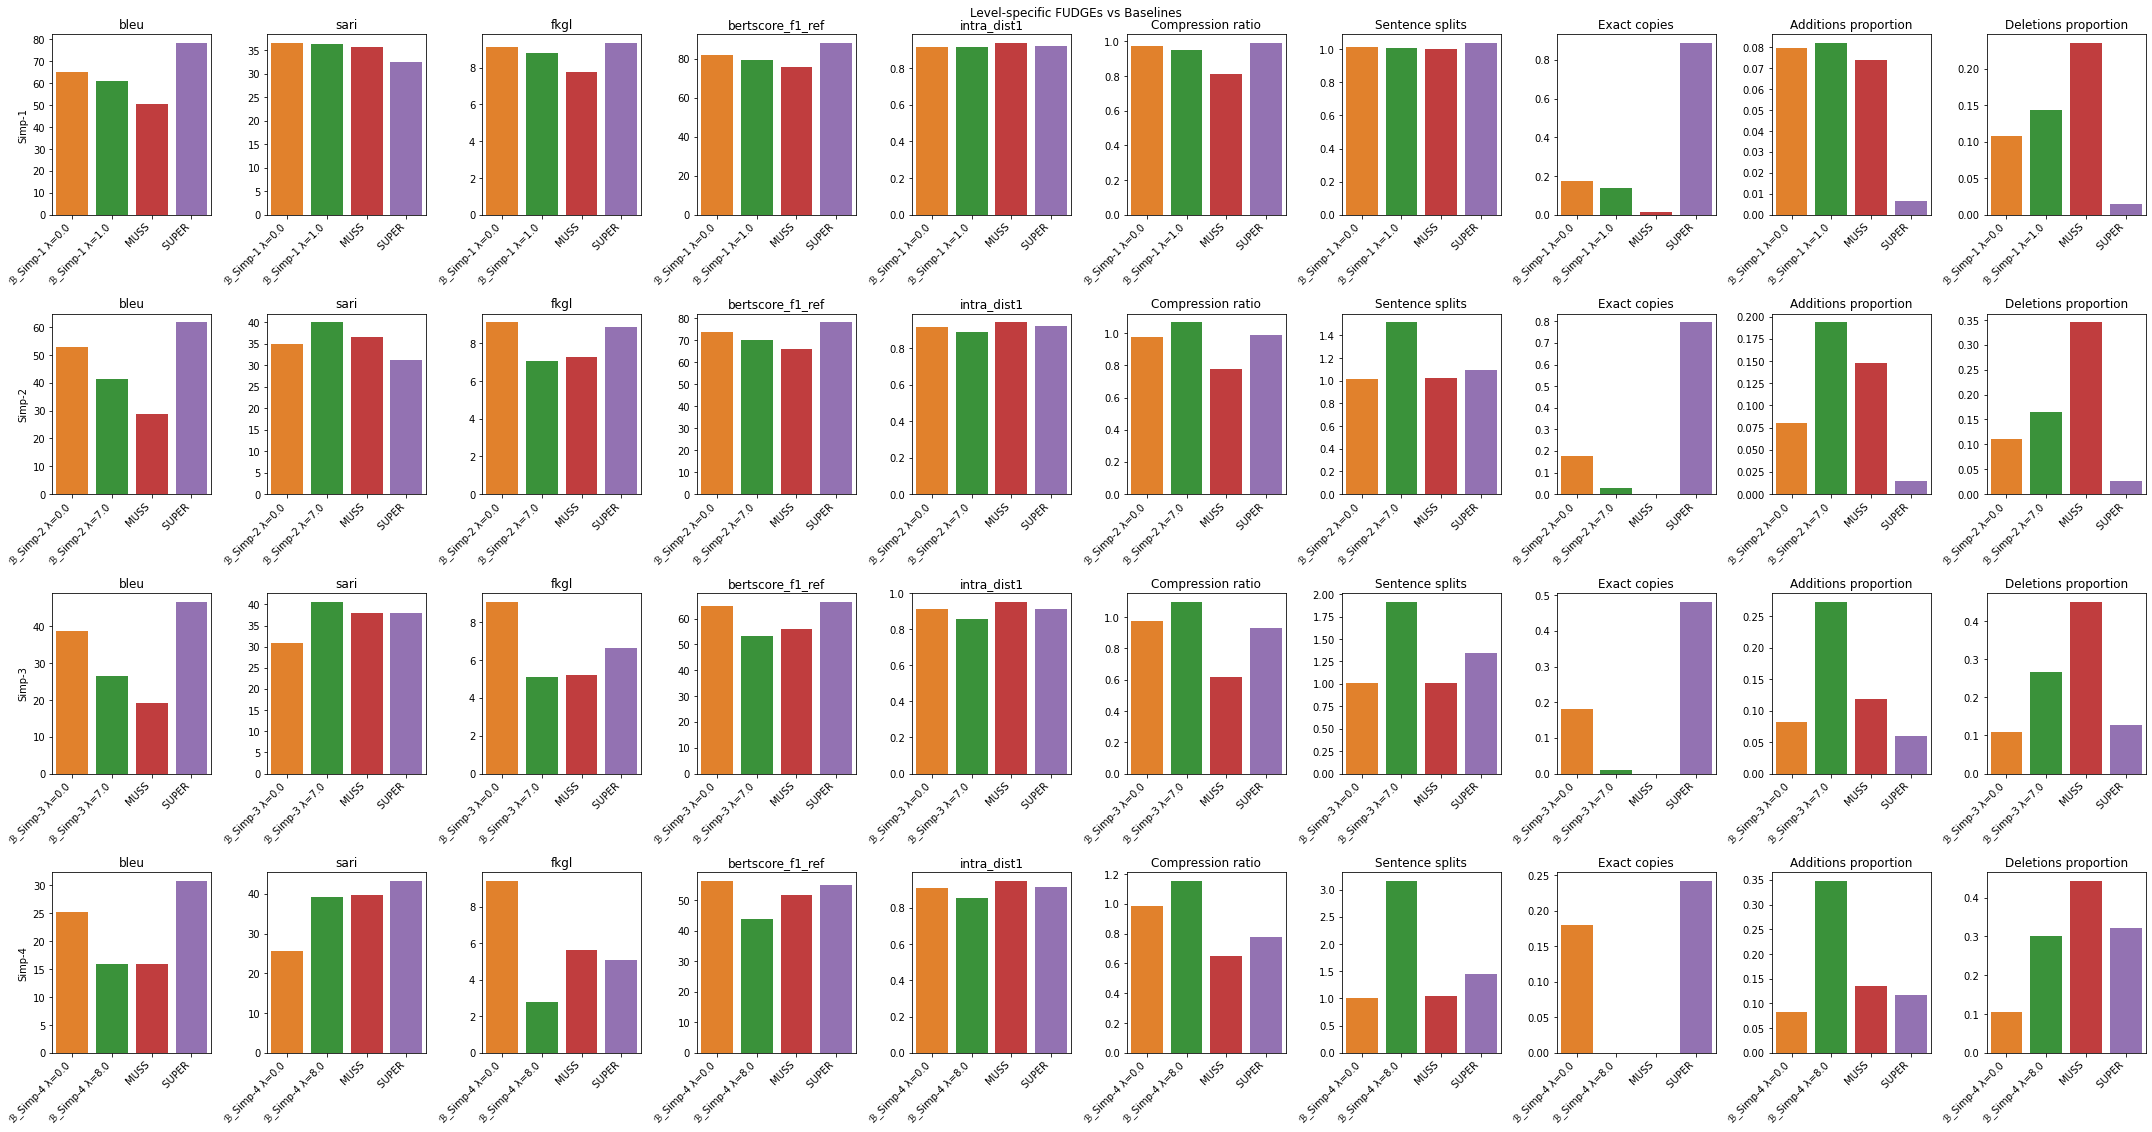

In [70]:
plot_results(df, title='Level-specific FUDGEs vs Baselines', outpath=plot_path)

In [5]:
df = read_data('/home/user/kew/INSTALLS/fudge/results_on_test.csv')
df = generate_results_table_for_newsela4_classifier_on_all_levels(df)
df
# plot_results(df, title='Newsela L4 Discriminiator vs Baselines', outpath=plot_path)

Index(['file', 'ppl_diff', 'bleu', 'sari', 'fkgl', 'bertscore_p_ref',
       'bertscore_r_ref', 'bertscore_f1_ref', 'bertscore_p_src',
       'bertscore_r_src', 'bertscore_f1_src', 'intra_dist1', 'intra_dist2',
       'inter_dist1', 'inter_dist2', 'Compression ratio', 'Sentence splits',
       'Levenshtein similarity', 'Exact copies', 'Additions proportion',
       'Deletions proportion', 'Lexical complexity score'],
      dtype='object')
48
44
26
21


,test_set,split,method,params,bleu,sari,fkgl,bertscore_f1_ref,bertscore_f1_src,intra_dist1,intra_dist2,Compression ratio,Sentence splits,Levenshtein similarity,Exact copies,Additions proportion,Deletions proportion,Lexical complexity score,file
0,L0-L1,test,fudge,L4-lambda1.0,56.422533,36.262023,8.220763,78.010470,85.254711,0.919195,0.977543,0.914792,1.047580,0.848761,0.068493,0.089516,0.184671,8.587172,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
1,L0-L1,test,fudge,L4-lambda2.0,53.528484,37.654994,7.175583,76.399809,82.814431,0.914410,0.973957,0.917303,1.185936,0.828577,0.049315,0.122458,0.212663,8.572986,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
2,L0-L1,test,muss,-muss,50.607168,35.689195,7.752044,75.949240,82.263905,0.937497,0.996012,0.811370,1.003425,0.844320,0.013699,0.074010,0.235342,8.490906,/srv/scratch6/kew/ats/muss/outputs/newsela_manual_v0_v1_test_lr0.3_ls0.99_wr0.54_td1.45.pred
3,L0-L1,test,supervised,-labeled,78.491987,32.494886,9.357700,88.186944,98.418158,0.920551,0.991328,0.991141,1.038813,0.990262,0.887671,0.006629,0.014658,8.613136,/srv/scratch6/kew/ats/supervised/results/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_topp1.0_bs1.txt
4,L0-L2,test,fudge,L2-lambda7.0,41.337300,39.993732,7.083326,70.027119,82.567096,0.887200,0.971533,1.067819,1.517328,0.814258,0.028329,0.193831,0.165013,8.485724,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
5,L0-L2,test,fudge,L4-lambda2.0,44.192605,38.672545,7.263657,68.478817,81.251770,0.911477,0.976075,0.894024,1.179509,0.817988,0.050992,0.126713,0.228373,8.543940,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
6,L0-L2,test,fudge,L4-lambda2.0,44.769235,39.262633,7.119653,70.135915,83.103245,0.914356,0.976755,0.917293,1.192257,0.831350,0.048159,0.122408,0.211093,8.558858,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
7,L0-L2,test,fudge,L4-lambda3.0,42.088422,40.116801,6.367959,67.382777,79.255933,0.901898,0.976693,0.940769,1.376157,0.805006,0.031161,0.165251,0.234372,8.503544,/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda3.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt
8,L0-L2,test,muss,-muss,28.724531,36.566496,7.269932,65.907264,76.076239,0.941795,0.996166,0.778172,1.025260,0.752531,0.002833,0.147472,0.345488,8.517329,/srv/scratch6/kew/ats/muss/outputs/newsela_manual_v0_v2_test_lr0.75_ls0.82_wr0.94_td0.22.pred
9,L0-L2,test,supervised,-labeled,61.781532,31.119814,8.877532,78.216690,96.989560,0.919900,0.985710,0.990798,1.095467,0.978994,0.796034,0.015011,0.026788,8.599498,/srv/scratch6/kew/ats/supervised/results/newsela_manual_v0_v2_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_topp1.0_bs1.tx

Index(['file', 'ppl_diff', 'bleu', 'sari', 'fkgl', 'bertscore_p',
       'bertscore_r', 'bertscore_f1', 'Compression ratio', 'Sentence splits',
       'Levenshtein similarity', 'Exact copies', 'Additions proportion',
       'Deletions proportion', 'Lexical complexity score'],
      dtype='object')
30
22
20


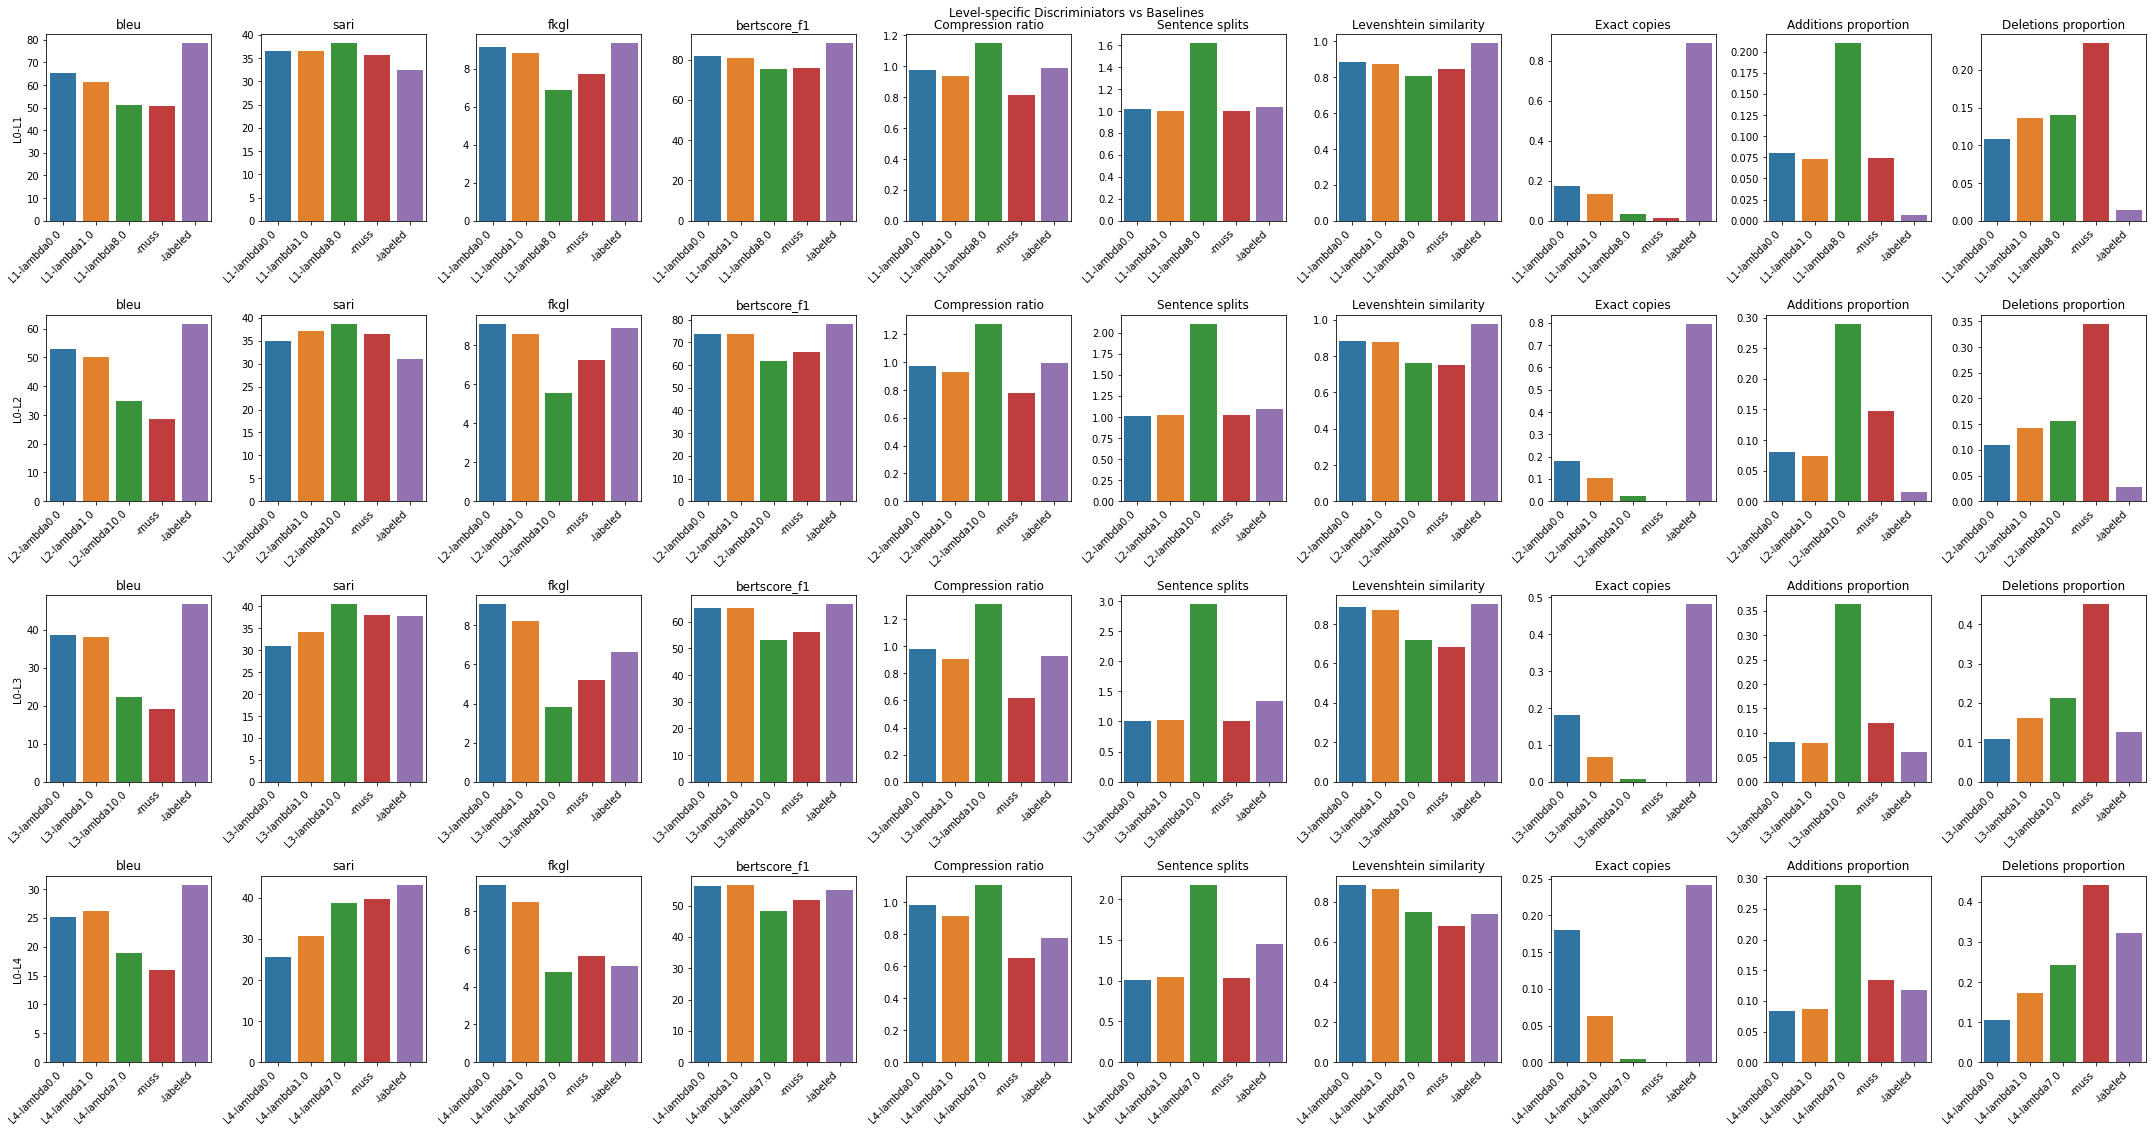

In [155]:
df = read_data('/home/user/kew/INSTALLS/fudge/results_on_test.csv')
df = generate_results_table_for_controlled_simplification_levels(df)
plot_results(df, title='Level-specific Discriminiators vs Baselines', outpath=plot_path)

Index(['file', 'ppl_diff', 'bleu', 'sari', 'fkgl', 'bertscore_p',
       'bertscore_r', 'bertscore_f1', 'Compression ratio', 'Sentence splits',
       'Levenshtein similarity', 'Exact copies', 'Additions proportion',
       'Deletions proportion', 'Lexical complexity score'],
      dtype='object')
34
30
28


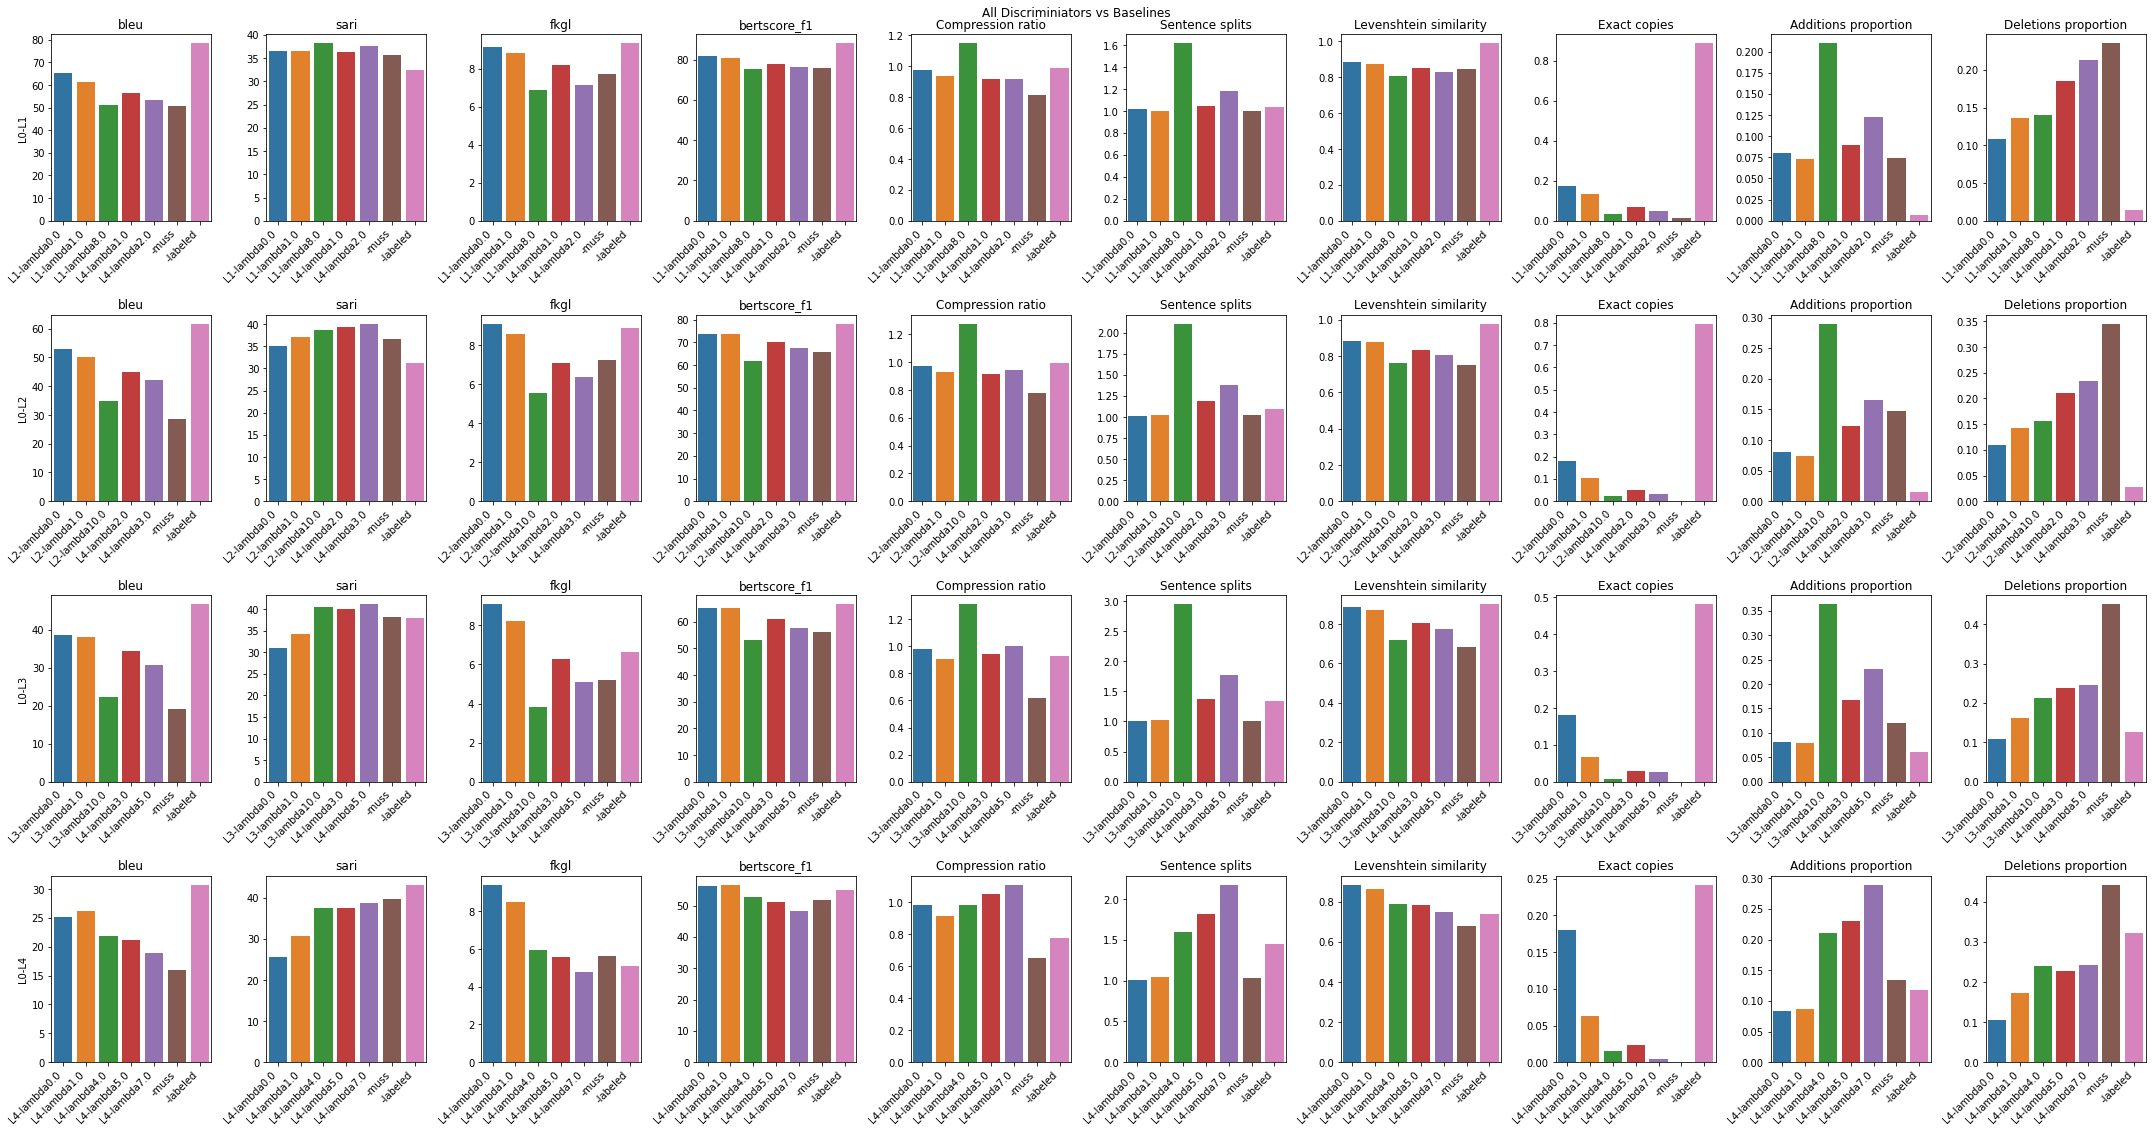

In [156]:
df = read_data('/home/user/kew/INSTALLS/fudge/results_on_test.csv')
df = generate_large_results_table(df)
plot_results(df, title='All Discriminiators vs Baselines', outpath=plot_path)

In [72]:
# def plot_results(df, level='0-1', split='test', outpath=None):

#     sub_df = df[(df['test_set'] == level) & (df['split'] == split)]
# #     print(len(sub_df))
# #     sub_df = sub_df[(sub_df['params'] != 'L4-lambda4.0')]
    
#     cols = sub_df.select_dtypes(include=np.number).columns.tolist()[:10]
# #     print(cols)

#     fig, axes = plt.subplots(1, len(cols), figsize = (35, 5))

#     for i, col in enumerate(cols):
# #         print(col)
#         sns.barplot(y=col, x='params', data=sub_df, ax=axes[i])
            
#         axes[i].set_xticklabels(
#             axes[i].get_xticklabels(), 
#             rotation=45, 
#             horizontalalignment='right'
#         )
    
#         # swap ylabel for axis title
#         axes[i].set_title(axes[i].get_ylabel())
#         axes[i].set_ylabel(None)
        
#     fig.suptitle(f'{split} {level}')
    
# #     if outpath:
# #         plt.savefig(outpath / f'{split}_{level}')
    
#     return

# for split in ['test']:
#     for level in ['L0-L1', 'L0-L2', 'L0-L3', 'L0-L4']:
#         plot_results(df, level, split)

In [ ]:
# df = generate_results_table_for_controlled_simplification_levels('/home/user/kew/INSTALLS/fudge/results.csv')
# df
# df.to_clipboard(excel=True)

In [21]:
from collections import Counter
def get_additions_proportion(complex_sentence, simple_sentence):
    n_additions = sum((Counter(simple_sentence) - Counter(complex_sentence)).values())
    print(n_additions)
    return n_additions / max(len(complex_sentence), len(simple_sentence))

get_additions_proportion(
    'this is a complex sentence .'.split(), 
    'this is a simple sentences . it has more words .'.split()
)

7


0.6363636363636364

In [22]:
7/11

0.6363636363636364

1.1666666666666667